## **Image-to-Image Translation using CycleGAN**

### **Importing Modules**

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [0]:
from random import random
from numpy import load
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from numpy import zeros
from numpy import ones
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

### **Data Preprocessing**

In [0]:
import zipfile
with zipfile.ZipFile('/content/horse2zebra.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [0]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
 
def load_images(path, size=(256,256)):
	images = list()
	for filename in listdir(path):
		image = load_img(path + filename, target_size=size)
		image = img_to_array(image)
		images.append(image)
	return asarray(images)

train_A = load_images('/content/dataset/horse2zebra/trainA/')
test_A = load_images('/content/dataset/horse2zebra/testA/')
data_A = vstack((train_A, test_A))
train_B = load_images('/content/dataset/horse2zebra/trainB/')
test_B = load_images('/content/dataset/horse2zebra/testB/')
data_B = vstack((train_B, test_B))
filename = 'horse2zebra_256.npz'
savez_compressed(filename, data_A, data_B)
print('Combined Data for Train and Test and Saved as .npz: ', filename)

Combined Data for Train and Test and Saved as .npz:  horse2zebra_256.npz


### **Load Data**

In [0]:
from numpy import load
data = load('horse2zebra_256.npz')
data_A, data_B = data['arr_0'], data['arr_1']

### **Checking Training Data**

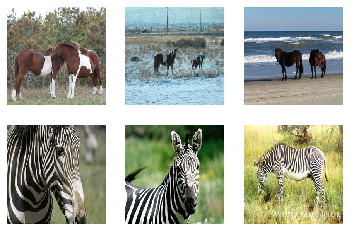

In [0]:
from matplotlib import pyplot
n_samples = 3
n_rows = 2
for i in range(n_samples):
	pyplot.subplot(n_rows, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(data_A[i].astype('uint8'))
for i in range(n_samples):
	pyplot.subplot(n_rows, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(data_B[i].astype('uint8'))
pyplot.show()


### **Scaling Loaded Data**

In [0]:
def scaling_data(data_A, data_B):
	data_A = (data_A - 127.5) / 127.5
	data_B = (data_B - 127.5) / 127.5
	return [data_A, data_B]

### **Randomly get 'n' Real Images**

In [0]:
def get_real_samples(dataset, n_samples, patch_shape):
	index = randint(0, dataset.shape[0], n_samples)
	X = dataset[index]
	Y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, Y

### **Generate fake images with input from source domain (Real Images)**

In [0]:
def get_fake_samples(generator, dataset, patch_shape):
	X = generator.predict(dataset)
	Y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, Y

### **Maintaining and Updating Image Pool**

In [0]:
from random import random
def image_pool(pool, fake_images, size=50):
	selected_images = list()
	for image in fake_images:
		if len(pool) < size:
			pool.append(image)
			selected_images.append(image)
		elif random() < 0.5:
			selected_images.append(image)
		else:
			index = randint(0, len(pool))
			selected_images.append(pool[index])
			pool[index] = image
	return asarray(selected_images)

### **Discriminator Model**

In [0]:
from keras.initializers import RandomNormal
def discriminator(image_shape=(256,256,3)):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
 
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)

	model = Model(in_image, patch_out)

	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [0]:
model = discriminator()
model.summary()
#SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 256)       524

### **Residual Network Block (ResNet Block)**

In [0]:
def resnet_block(n_filters, input_layer):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Concatenate()([g, input_layer])
	return g

### **Generator Model**

In [0]:
def generator(image_shape=(256,256,3), n_resnet=9):
  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)
  g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
	
  g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
	
  g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
  
  for i in range(n_resnet):
    g = resnet_block(256, g)
  
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
  
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
  
  g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  out_image = Activation('tanh')(g)
  
  model = Model(in_image, out_image)
  return model

In [0]:
model = generator()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 256, 256, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
instance_normalization_5 (Insta (None, 256, 256, 64) 128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           instance_normalization_5[0][0]   
____________________________________________________________________________________________

### **Combined Model**

In [0]:
def combined_model(generator_1, discriminator, generator_2, image_shape=(256,256,3)):
  generator_1.trainable = True
  discriminator.trainable = False
  generator_2.trainable = False
  input_generator = Input(shape=image_shape)
  output_g1 = generator_1(input_generator)
  output_d = discriminator(output_g1)
  input_identity = Input(shape=image_shape)
  output_identity = generator_1(input_identity)
  output_forward = generator_2(output_g1)
  output_g2 = generator_2(input_identity)
  output_backward = generator_1(output_g2)
  model = Model([input_generator, input_identity], [output_d, output_identity, output_forward, output_backward])
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
  return model

### **Evaluate Performance after Every nth Iteration**

In [0]:
def evaluate_performance(iteration, generator , dataA, name , n_samples=5):
	X_in, _ = get_real_samples(dataA, n_samples, 0)
	X_out, _ = get_fake_samples(generator, X_in, 0)
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	filename = "/content/drive/My Drive/CycleGAN/Generated_Plot/%s_generated_plot_%06d.png" % (name, (iteration+1))
	pyplot.savefig(filename)
	pyplot.close()

### **Training Model**

In [0]:
from tqdm import tqdm
def train(epochs,batch_size,discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, combined_AtoB, combined_BtoA, dataA, dataB):
  patch_dout = discriminator_A.output_shape[1]
  poolA, poolB = list(), list()
  bat_per_epoch = int(len(dataA) / batch_size)
  iterations = bat_per_epoch * epochs
  for i in tqdm(range(iterations)):
    X_realA, y_realA = get_real_samples(dataA, batch_size, patch_dout) 
    X_realB, y_realB = get_real_samples(dataB, batch_size, patch_dout)
    X_fakeA, y_fakeA = get_fake_samples(generator_BtoA, X_realB, patch_dout)
    X_fakeB, y_fakeB = get_fake_samples(generator_AtoB, X_realA, patch_dout)
    X_fakeA = image_pool(poolA, X_fakeA)
    X_fakeB = image_pool(poolB, X_fakeB)
    generator_loss2 = combined_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
    d_A_loss1 = discriminator_A.train_on_batch(X_realA, y_realA)
    d_A_loss2 = discriminator_A.train_on_batch(X_fakeA, y_fakeA)
    generator_loss1 = combined_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
    d_B_loss1 = discriminator_B.train_on_batch(X_realB, y_realB)
    d_B_loss2 = discriminator_B.train_on_batch(X_fakeB, y_fakeB)
    f = open("/content/drive/My Drive/CycleGAN/mylogs/iteration_data.txt",'a')
    f.write("\n%06d | DA_LOSS1_R: %.2f | DA_LOSS2_F: %.2f%% | DB_LOSS1_R: %.2f | DB_LOSS2_F: %.2f%% | G_LOSS1: %.2f | G_LOSS2: %.2f%%" %(i+1,d_A_loss1,d_A_loss2, d_B_loss1,d_B_loss2, generator_loss1,generator_loss2))
    f.close()
    if (i+1) % (1000) == 0:
      evaluate_performance(i, generator_AtoB, dataA, 'AtoB')
      evaluate_performance(i, generator_BtoA, dataB, 'BtoA')
    if (i+1) % (10000) == 0:
      filename_g_AtoB = "/content/drive/My Drive/CycleGAN/model/G_AtoB/generator_AtoB%d.h5" % (i+1)
      filename_g_BtoA = "/content/drive/My Drive/CycleGAN/model/G_BtoA/generator_BtoA%d.h5" % (i+1)
      generator_AtoB.save(filename_g_AtoB)
      generator_BtoA.save(filename_g_BtoA)
  

### **Start Training**

In [0]:

image_shape = data_A.shape[1:]

generator_AtoB = generator(image_shape)
generator_BtoA = generator(image_shape)
discriminator_A = discriminator(image_shape)
discriminator_B = discriminator(image_shape)
combined_AtoB = combined_model(generator_AtoB, discriminator_B, generator_BtoA, image_shape)
combined_BtoA = combined_model(generator_BtoA, discriminator_A, generator_AtoB, image_shape)
train(50,1,discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, combined_AtoB, combined_BtoA, data_A,data_B)


  0%|          | 0/59350 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepan

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


(256, 256, 3)